<a href="https://colab.research.google.com/github/LizCarter492/EnvDatSci/blob/main/CodeSprints/FeatureDependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Feature Dependence and Regression Analysis
In this example, we will be using a spatial dataset of county-level election and demographic statistics for the United States. We'll explore different methods to diagnose and account for multicollinearity in our data in regression analysis. Specifically, we'll calculate variance inflation factor (VIF), and compare parameter estimates and model fit in a multivariate regression predicting 2016 county voting preferences using an OLS model, a ridge regression, a lasso regression, and an elastic net regression.

Objectives:
* **Calculate a variance inflation factor to diagnose multicollinearity.**
* **Interpret model summary statistics.**
* **Describe how multicollinearity impacts stability in parameter esimates.**
* **Explain the variance/bias tradeoff and describe how to use it to improve models**
* **Draw a conclusion based on contrasting models.**



In [2]:
%%capture
!pip install geopandas
!pip install libpysal
!pip install statsmodels
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

In [3]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from numpy import mean
from numpy import std
from numpy import absolute
from libpysal.weights.contiguity import Queen
import libpysal
from statsmodels.api import OLS
sns.set_style('white')

/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


First, we're going to load the 'Elections' dataset from the libpysal library, which is a very easy to use API that accesses the Geodata Center at the University of Chicago.

* More on spatial data science resources from UC: https://spatial.uchicago.edu/
* A list of datasets available through lipysal: https://geodacenter.github.io/data-and-lab//

In [4]:
from libpysal.examples import load_example
elections = load_example('Elections')
#note the folder where your data now lives:


In [5]:
#First, let's see what files are available in the 'Elections' data example
elections.get_file_list()

['/Users/liyangqin/Library/Application Support/pysal/Elections/__MACOSX/election/._election.shp',
 '/Users/liyangqin/Library/Application Support/pysal/Elections/election/election.prj',
 '/Users/liyangqin/Library/Application Support/pysal/Elections/election/election.shx',
 '/Users/liyangqin/Library/Application Support/pysal/Elections/election/election.shp',
 '/Users/liyangqin/Library/Application Support/pysal/Elections/election/election.dbf']

When you are out in the world doing research, you often will not find a ready-made function to download your data. That's okay! You know how to get this dataset without using pysal! Do a quick internal review of online data formats and automatic data downloads.

### TASK 1: Use urllib functions to download this file directly from the internet a folder (not in your git repository). Extract the zipped file you've downloaded into a subfolder called elections.

In [9]:
# Task 1 code here:
import os as os
import urllib.request
import zipfile

url = "https://geodacenter.github.io/data-and-lab//data/election.zip"
downloadfolder = "/Users/liyangqin/earth-analytics"
download_path = os.path.join(downloadfolder, 'election.zip')
extract_folder = os.path.join(downloadfolder, "elections")

urllib.request.urlretrieve(url, download_path)

os.makedirs(extract_folder, exist_ok = True)

with zipfile.ZipFile(download_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)

### TASK 2: Use geopandas to read in this shapefile. Call your geopandas.DataFrame "votes"

In [ ]:
# TASK 2: Use geopandas to read in this shapefile. Call your geopandas.DataFrame "votes"
shapefile_path = os.path.join(extract_folder, "election/election.shp")

votes = gpd.read_file(shapefile_path)


  STATEFP COUNTYFP  GEOID         ALAND      AWATER       area_name  \
0      01      005  01005  2.291821e+09  50864677.0  Barbour County   
1      01      023  01023  2.365955e+09  19059247.0  Choctaw County   
2      01      035  01035  2.201896e+09   6643480.0  Conecuh County   
3      01      051  01051  1.601877e+09  99850740.0   Elmore County   
4      01      065  01065  1.667805e+09  32525874.0     Hale County   

  state_abbr  PST045214  PST040210  PST120214  ...  total_2012  Demvotes12  \
0         AL    26887.0    27457.0       -2.1  ...     11459.0      5873.0   
1         AL    13323.0    13858.0       -3.9  ...      7965.0      3785.0   
2         AL    12670.0    13228.0       -4.2  ...      7013.0      3551.0   
3         AL    80977.0    79296.0        2.1  ...     35440.0      8940.0   
4         AL    15184.0    15760.0       -3.7  ...      8628.0      5401.0   

   GOPvotes12  county_fip  state_fips  pct_dem_12  pct_gop_12  diff_2012  \
0      5539.0         5.0   

<Axes: >

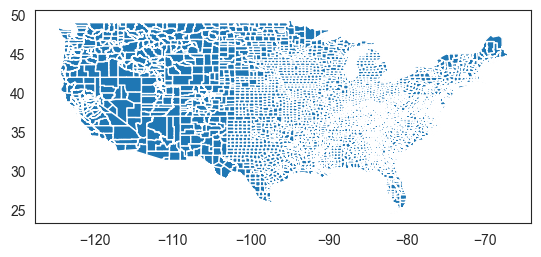

In [12]:
#Let's view the shapefile to get a general idea of the geometry we're looking at:
%matplotlib inline
votes.plot()

In [13]:
#View the first few lines of the dataset
votes.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,total_2012,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,geometry
0,01,005,01005,2.291821e+09,50864677.0,Barbour County,AL,26887.0,27457.0,-2.1,...,11459.0,5873.0,5539.0,5.0,1.0,0.512523,0.483376,334.0,0.029147,"POLYGON ((-85.748 31.619, -85.745 31.619, -85...."
1,01,023,01023,2.365955e+09,19059247.0,Choctaw County,AL,13323.0,13858.0,-3.9,...,7965.0,3785.0,4150.0,23.0,1.0,0.475204,0.521030,365.0,-0.045825,"POLYGON ((-88.473 31.894, -88.469 31.93, -88.4..."
2,01,035,01035,2.201896e+09,6643480.0,Conecuh County,AL,12670.0,13228.0,-4.2,...,7013.0,3551.0,3434.0,35.0,1.0,0.506345,0.489662,117.0,0.016683,"POLYGON ((-87.427 31.264, -87.426 31.268, -87...."
3,01,051,01051,1.601877e+09,99850740.0,Elmore County,AL,80977.0,79296.0,2.1,...,35440.0,8940.0,26223.0,51.0,1.0,0.252257,0.739927,17283.0,-0.487669,"POLYGON ((-86.413 32.751, -86.371 32.751, -86...."
4,01,065,01065,1.667805e+09,32525874.0,Hale County,AL,15184.0,15760.0,-3.7,...,8628.0,5401.0,3205.0,65.0,1.0,0.625985,0.371465,2196.0,0.254520,"POLYGON ((-87.87 32.762, -87.868 32.766, -87.8..."


In [14]:
#Since there are too many columns for us to view on a signle page using "head", we can just print out the column names so we have them all listed for reference
for col in votes.columns:
    print(col)

STATEFP
COUNTYFP
GEOID
ALAND
AWATER
area_name
state_abbr
PST045214
PST040210
PST120214
POP010210
AGE135214
AGE295214
AGE775214
SEX255214
RHI125214
RHI225214
RHI325214
RHI425214
RHI525214
RHI625214
RHI725214
RHI825214
POP715213
POP645213
POP815213
EDU635213
EDU685213
VET605213
LFE305213
HSG010214
HSG445213
HSG096213
HSG495213
HSD410213
HSD310213
INC910213
INC110213
PVY020213
BZA010213
BZA110213
BZA115213
NES010213
SBO001207
SBO315207
SBO115207
SBO215207
SBO515207
SBO415207
SBO015207
MAN450207
WTN220207
RTN130207
RTN131207
AFN120207
BPS030214
LND110210
POP060210
Demvotes16
GOPvotes16
total_2016
pct_dem_16
pct_gop_16
diff_2016
pct_pt_16
total_2012
Demvotes12
GOPvotes12
county_fip
state_fips
pct_dem_12
pct_gop_12
diff_2012
pct_pt_12
geometry


#### You can use pandas summary statistics to get an idea of how county-level data varies across the United States.
### TASK 3: For example, how did the county mean percent Democratic vote change between 2012 (pct_dem_12) and 2016 (pct_dem_16)?

Look here for more info on pandas dataframes:

https://www.earthdatascience.org/courses/intro-to-earth-data-science/scientific-data-structures-python/pandas-dataframes/run-calculations-summary-statistics-pandas-dataframes/

In [27]:
# Task 3
mean_pct_dem_12 = votes["pct_dem_12"].mean()
mean_pct_dem_16 = votes["pct_dem_16"].mean()

pct_vote_diff = mean_pct_dem_16 - mean_pct_dem_12


print(mean_pct_dem_12)
print(mean_pct_dem_16)
print(pct_vote_diff)
print(f"the county mean percent Democratic vote between 2012 (pct_dem_12) and 2016 (pct_dem_16) dropped by {abs(pct_vote_diff):.2f}%"
)

0.384501897042471
0.31666743004440157
-0.06783446699806944
the county mean percent Democratic vote between 2012 (pct_dem_12) and 2016 (pct_dem_16) dropped by 0.07%


We can also plot histograms of the data. Below, smoothed histograms from the seaborn package (imported as sns) let us get an idea of the distribution of percent democratic votes in 2012 (left) and 2016 (right).

/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/393966224.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])
/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/393966224.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])


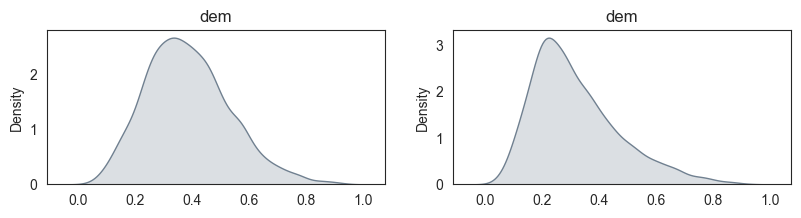

In [28]:
# Plot histograms:
f,ax = plt.subplots(1,2, figsize=(2*3*1.6, 2))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    sns.kdeplot(votes[col].values, shade=True, color='slategrey', ax=ax[i])
    ax[i].set_title(col.split('_')[1])

/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/3954375980.py:8: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/3954375980.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/3954375980.py:8: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
/var/folders/3h/x_sz2_zj2zx2

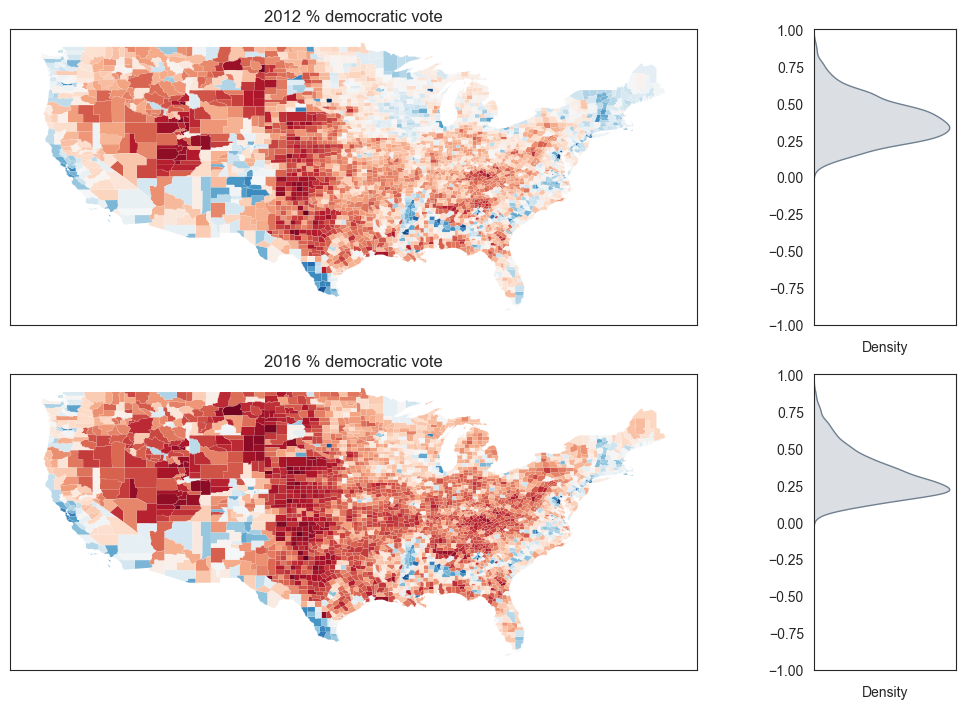

In [29]:
# Plot spatial distribution of # dem vote in 2012 and 2016 with histogram.
f,ax = plt.subplots(2,2, figsize=(1.6*6 + 1,2.4*3), gridspec_kw=dict(width_ratios=(6,1)))
for i,col in enumerate(['pct_dem_12','pct_dem_16']):
    votes.plot(col, linewidth=.05, cmap='RdBu', ax=ax[i,0])
    ax[i,0].set_title(['2012','2016'][i] + " % democratic vote")
    ax[i,0].set_xticklabels('')
    ax[i,0].set_yticklabels('')
    sns.kdeplot(votes[col].values, ax=ax[i,1], vertical=True, shade=True, color='slategrey')
    ax[i,1].set_xticklabels('')
    ax[i,1].set_ylim(-1,1)
f.tight_layout()
plt.show()

### TASK 4: Make a new column on your geopandas dataframe called "pct_dem_change" and plot it using the syntax above. Explain the plot.

In [30]:
# Task 4: add new column pct_dem_change to votes:
votes["pct_dem_change"] = votes["pct_dem_16"] - votes["pct_dem_12"]

/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/1923156206.py:8: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[1], vertical=True, shade=True, color='slategrey')
/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/1923156206.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes[col].values, ax=ax[1], vertical=True, shade=True, color='slategrey')


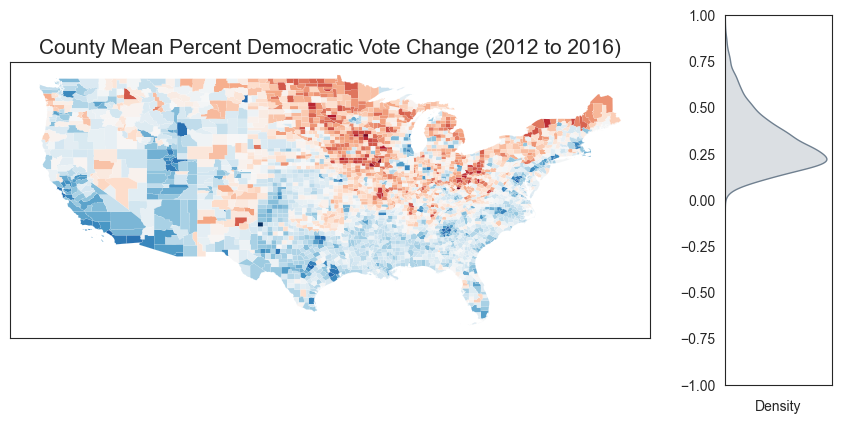

In [47]:
# Task 4: plot your pct_dem_change variable on a map:
f,ax = plt.subplots(1,2, figsize=(1.6*6 + 1,1.6*3), gridspec_kw=dict(width_ratios=(6,1)))
votes.plot("pct_dem_change", linewidth=0.05, cmap="RdBu", ax=ax[0])
ax[0].set_title("County Mean Percent Democratic Vote Change (2012 to 2016)", fontsize=15)
ax[0].set_xticklabels('')
ax[0].set_yticklabels('')

sns.kdeplot(votes[col].values, ax=ax[1], vertical=True, shade=True, color='slategrey')
ax[1].set_xticklabels('')
ax[1].set_ylim(-1,1)

plt.show()

Click on this url to learn more about the variables in this dataset: https://geodacenter.github.io/data-and-lab//county_election_2012_2016-variables/

Let's say we want to learn more about what county-level factors influence percent change in democratic vote between (pct_dem_change).

There are two types of multicollinearity:

* *Intrinsic multicollinearity:* is an artifact of how we make observations. Often our measurements serve as proxies for some latent process (for example, we can measure percent silt, percent sand, and percent clay as proxies for the latent variable of soil texture). There will be slight variability in the information content between each proxy measurement, but they will not be independent of one another.

* *Incidental collinearity:* is an artifact of how we sample complex populations. If we collect data from a subsample of the landscape where we don't see all combinations of our predictor variables (do not have good cross replication across our variables). We often induce collinearity in our data just because we are limitted in our ability to sample the environment at the scale of temporal/spatial variability of our process of interest. Incidental collinearity is a model formulation problem.(See here for more info on how to avoid it: https://people.umass.edu/sdestef/NRC%20601/StudyDesignConcepts.pdf)

### TASK 5: Looking at the data description, pick two variables that you believe will be intrinsically multicollinear. List and describe these variables. Why do you think they are intrinsically related?

pct_dem_12 and pct_gop_12. Because they represent the percentage of votes that are for Democratic candidates and Republican candidates, respectively. And since the total percentage of votes should be added near 100% for the two parties, therefore, when one variable changes, the other will change in response, and this can be considered as intrinsic mulicollinearity.

## Multivariate regression in observational data:
Our next step is to formulate our predictive/diagnostic model. We want to create a subset of the "votes" geopandas data frame that contains ten predictor variables and our response variable (pct_pt_16) two variables you selected under TASK 1. First, create a list of the variables you'd like to select.

### TASK 6: Create a subset of votes called "my_list" containing only your selected predictor variables. Make sure you use the two variables selected under TASK 5, and eight additional variables

In [54]:
# Task 4: create a subset of votes called "my list" with all your subset variables.
# my_list = ["pct_pt_16", <list your variables here>]

# For example:
# my_list = [
#     "pct_dem_change",  # The number in diff_2016 expressed as a percent of the total votes. Negative if fewer votes were cast for the Democratic candidate
#     "PST120214",  # Population, percent change - April 1, 2010 to July 1, 2014
#     "SEX255214",  # Female persons, percent, 2014
#     "RHI125214",  # White alone, percent, 2014
#     "RHI225214",  # Black or African American alone, percent, 2014
#     "EDU685213",  # Bachelor’s degree or higher, percent of persons age 25+, 2009-2013
#     "VET605213",  # Veterans, 2009-2013
#     "HSG495213",  # Median value of owner-occupied housing units, 2009-2013
#     "HSD310213",  # Persons per household, 2009-2013
#     "INC910213",  # Per capita money income in past 12 months (2013 dollars), 2009-2013
#     "LND110210",  # Land area in square miles, 2010
# ]

my_list = [
    "pct_pt_16",  # The number in diff_2016 expressed as a percent of the total votes. Negative if fewer votes were cast for the Democratic candidate
    "PST120214",  # Population, percent change - April 1, 2010 to July 1, 2014
    "SEX255214",  # Female persons, percent, 2014
    "RHI125214",  # White alone, percent, 2014
    "RHI225214",  # Black or African American alone, percent, 2014
    "EDU685213",  # Bachelor’s degree or higher, percent of persons age 25+, 2009-2013
    "VET605213",  # Veterans, 2009-2013
    "HSG495213",  # Median value of owner-occupied housing units, 2009-2013
    "pct_gop_12",  # Votes for Republican candidate as percent of total votes
    "INC910213",  # Per capita money income in past 12 months (2013 dollars), 2009-2013
    "pct_dem_12",  # Votes for Democratic candidate as percent of total votes
]

In [55]:
#check to make sure all your columns are there:
votes[my_list].head()

,pct_pt_16,PST120214,SEX255214,RHI125214,RHI225214,EDU685213,VET605213,HSG495213,pct_gop_12,INC910213,pct_dem_12
0,-0.056112,-2.1,46.6,50.2,47.6,13.4,2120.0,89200.0,0.483376,16829.0,0.512523
1,-0.136626,-3.9,52.5,56.6,42.4,11.8,938.0,58200.0,0.521030,20323.0,0.475204
2,-0.052575,-4.2,51.9,52.1,46.2,8.8,1101.0,69600.0,0.489662,15605.0,0.506345
3,-0.519794,2.1,51.5,76.0,21.2,21.0,8364.0,144600.0,0.739927,23856.0,0.252257
4,0.199750,-3.7,52.8,40.8,58.1,12.8,995.0,79900.0,0.371465,18812.0,0.625985


### Scatterplot matrix
We call the process of getting to know your data (ranges and distributions of the data, as well as any relationships between variables) "exploratory data analysis". Pairwise plots of your variables, called scatterplots, can provide a lot of insight into the type of relationships you have between variables. A scatterplot matrix is a pairwise comparison of all variables in your dataset.

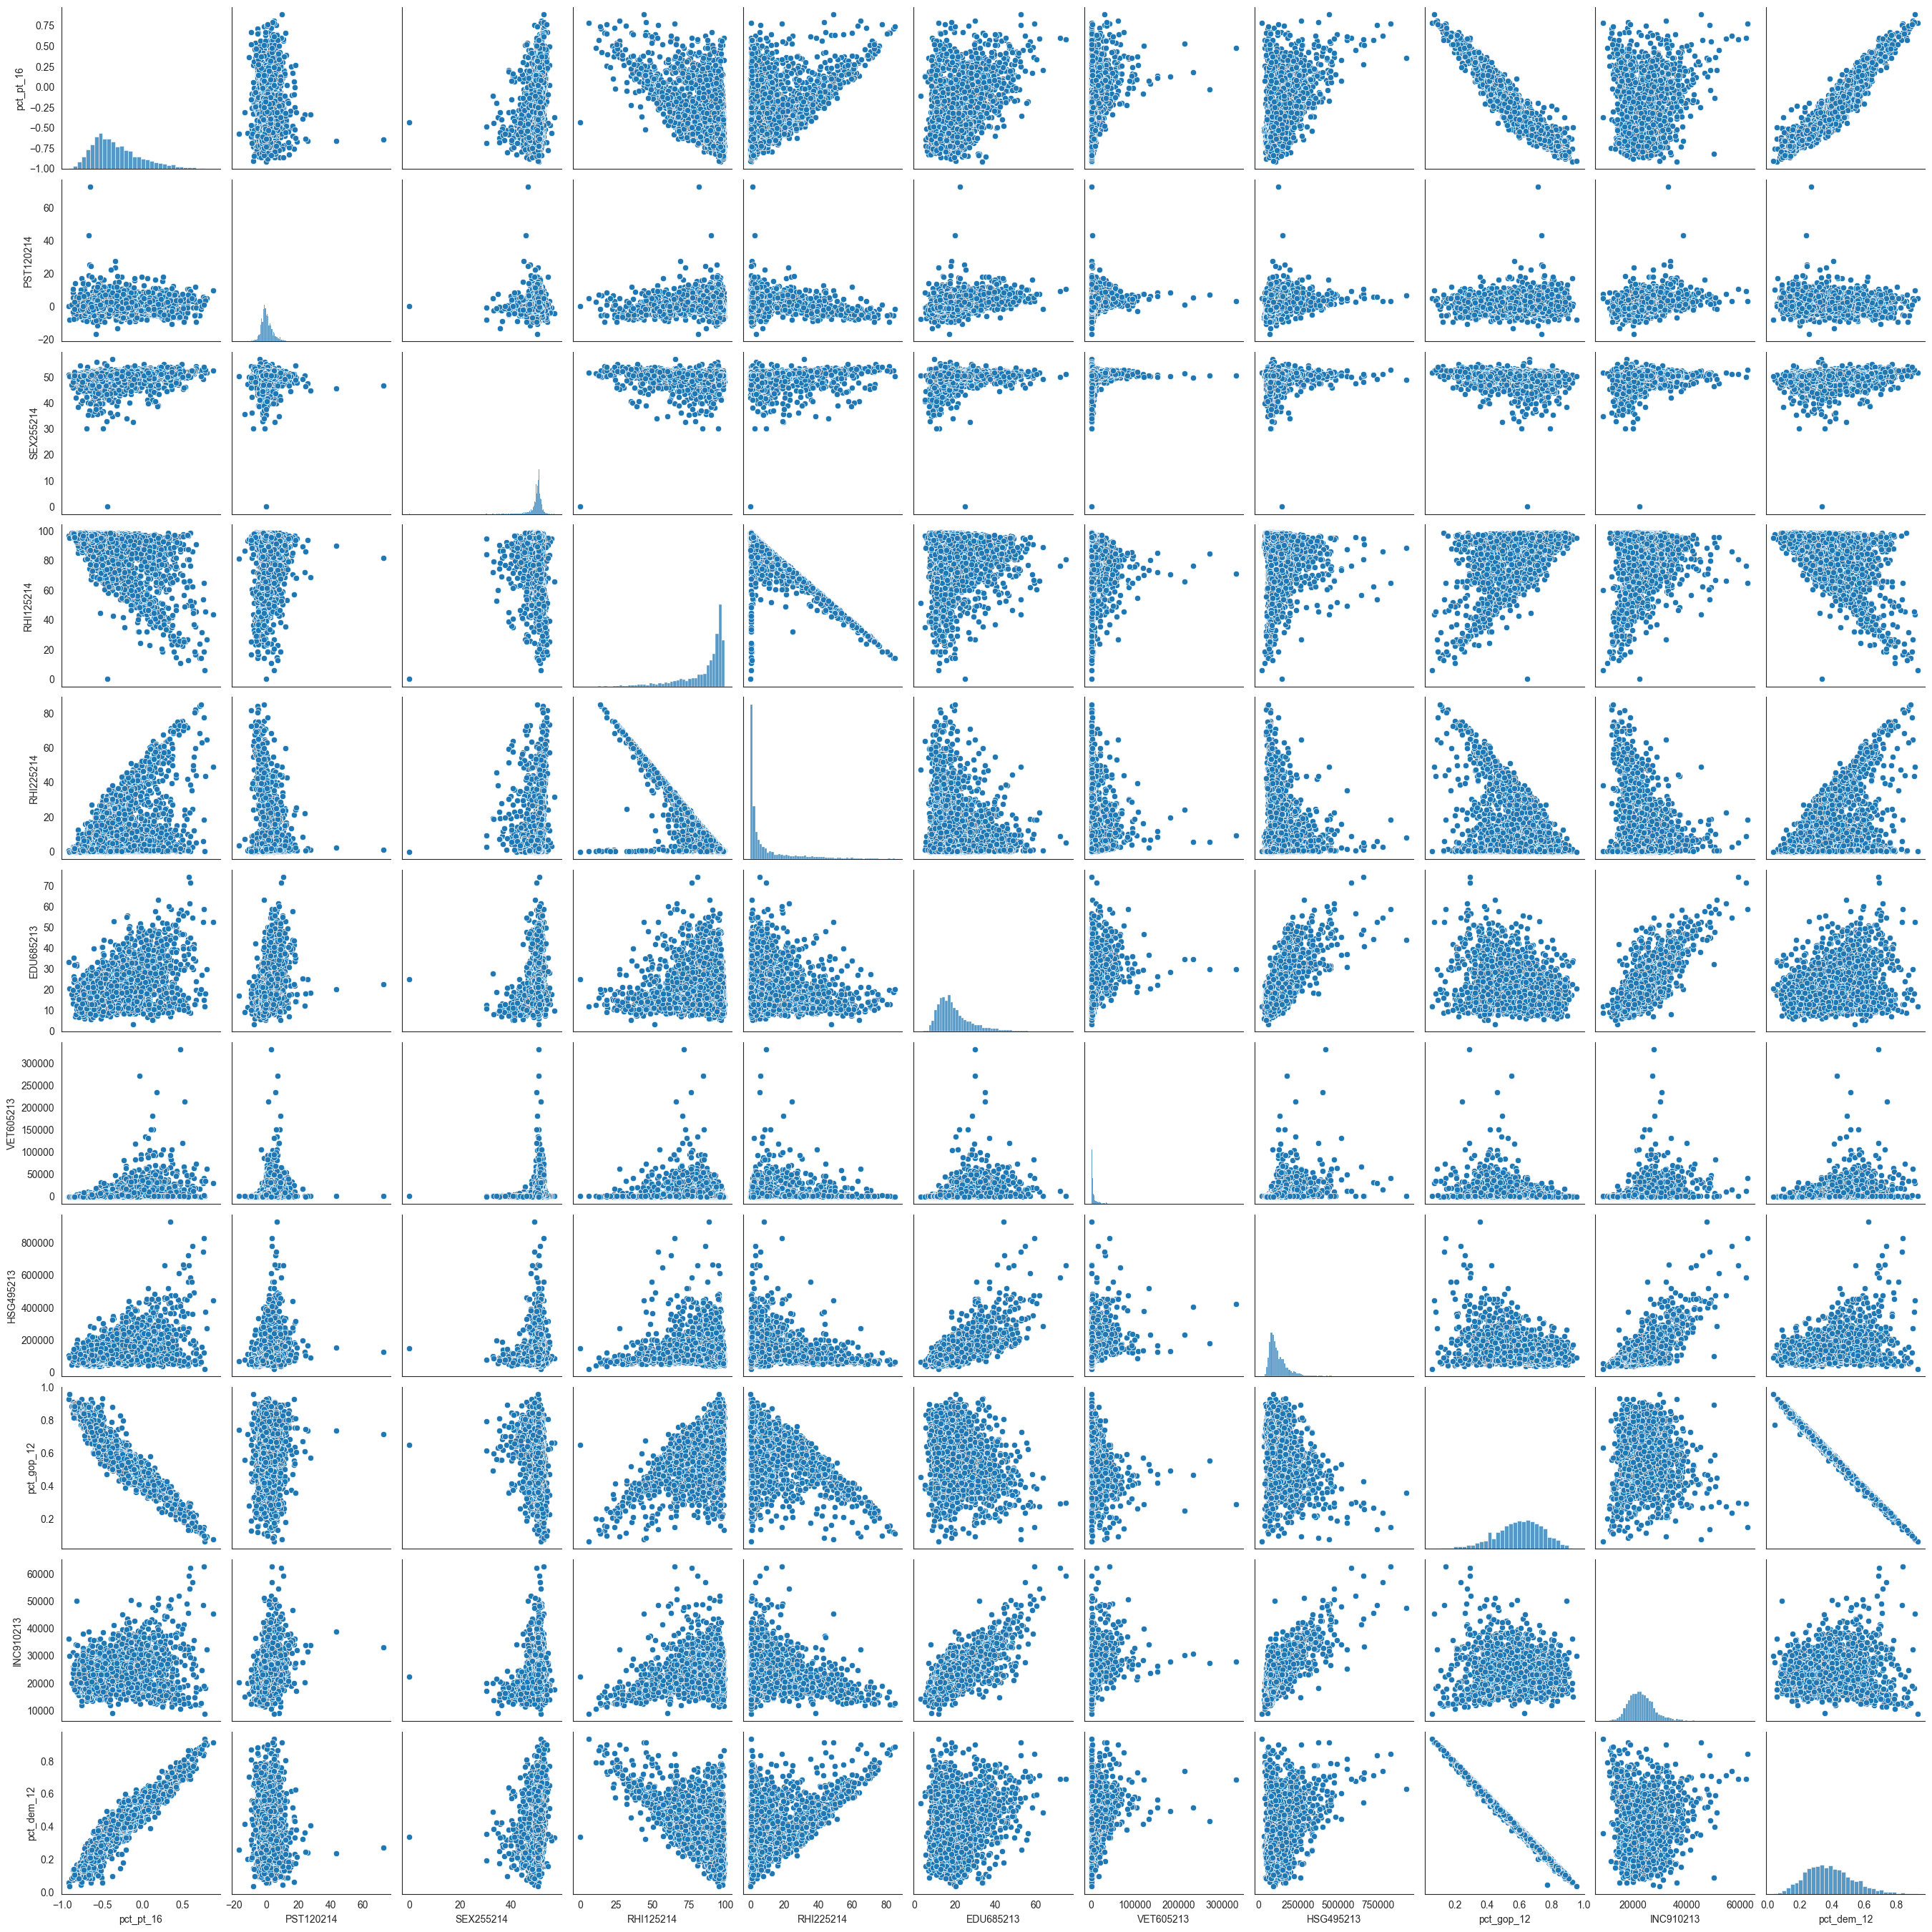

In [57]:
#Use seaborn.pairplot to plot a scatterplot matrix of you 10 variable subset:
sns.pairplot(votes[my_list])

### TASK 7: Do you observe any collinearity in this dataset? How would you describe the relationship between your two "incidentally collinear" variables that you selected based on looking at variable descriptions?

Yes, collinearity is observable in this dataset. Intrinsic collinearity occurs in between the two variable I selected "pct_dem_12" and "pct_gop_12". They show negative correlation, which demonstrates that as one is increasing, it would result in decreasing in another variable. Similarly, collinearity also occurs between "Black or African American alone" and "White alone" variables. Education and home income are also closely related to each other.

### TASK 8: What is plotted on the diagonal panels of the scatterplot matrix?

The diagonal panels in the scatterplot matrix contain the histograms (or density plots) of each individual variable. These histograms show the distribution of each variable independently, allowing us to assess aspects like skewness, central tendency, and variability of each variable. This helps provide insights into each variable's data distribution before considering relationships with other variables.


## Diagnosing collinearity globally:
Variance Inflation Factor describes the magnitude of variance inflation that can be expected in an OLS parameter estimate for a given variable *given pairwise collinearity between that variable and another variable*.

In [58]:
#VIF = 1/(1-R2) of a pairwise OLS regression between two predictor variables
#We can use a built-in function "variance_inflation_factor" from statsmodel.api to calculate VIF
#Learn more about the function
?variance_inflation_factor

Signature: variance_inflation_factor(exog, exog_idx)
Docstring:
Variance inflation factor, VIF, for one exogenous variable

The variance inflation factor is a measure for the increase of the
variance of the parameter estimates if an additional variable, given by
exog_idx is added to the linear regression. It is a measure for
multicollinearity of the design matrix, exog.

One recommendation is that if VIF is greater than 5, then the explanatory
variable given by exog_idx is highly collinear with the other explanatory
variables, and the parameter estimates will have large standard errors
because of this.

Parameters
----------
exog : {ndarray, DataFrame}
    design matrix with all explanatory variables, as for example used in
    regression
exog_idx : int
    index of the exogenous variable in the columns of exog

Returns
-------
float
    variance inflation factor

Notes
-----
This function does not save the auxiliary regression.

See Also
--------
xxx : class for regression diagnostics

In [59]:
#Calculate VIFs on our dataset
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(votes[my_list[1:11]].values, i) for i in range(votes[my_list[1:11]].shape[1])]
vif["features"] = votes[my_list[1:11]].columns


In [60]:
vif.round()

,VIF Factor,features
0,1.0,PST120214
1,475.0,SEX255214
2,153.0,RHI125214
3,7.0,RHI225214
4,20.0,EDU685213
5,1.0,VET605213
6,10.0,HSG495213
7,227.0,pct_gop_12
8,65.0,INC910213
9,103.0,pct_dem_12


### Collinearity is always present in observational data. When is it a problem?
Generally speaking, including any variables with VIF > 10 is considered "too much" collinearity. But this value is somewhat arbitrary. The extent to which variance inflation will impact your analysis is highly context dependent. There are two primary contexts where variance inflation is problematic:

 1\. **You are using your analysis to evaluate variable importance:** If you are using parameter estimates from your model to diagnose which observations have physically important relationships with your response variable, variance inflation can make an important predictor look unimportant, and parameter estimates will be highly leveraged by small changes in the data.

 2\. **You want to use your model to make predictions in a situation where the specific structure of collinearity between variables may have shifted:** When training a model on collinear data, the model only applies to data with that exact structure of collinearity.

### Caluculate a linear regression on the global data:
In this next step, we're going to calculate a linear regression in our data an determine whether there is a statistically significant relationship between per capita income and percent change in democratic vote.

In [63]:
#first, forumalate the model. See weather_trend.py in "Git_101" for a refresher on how.

#extract variable that you want to use to "predict"
X = np.array(votes[my_list[1:11]].values)
#standardize data to assist in interpretation of coefficients
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

#extract variable that we want to "predict"
Y = np.array(votes['pct_dem_change'].values)
#standardize data to assist in interpretation of coefficients
Y = (Y - np.mean(X)) / np.std(Y)

lm = OLS(Y,X)
lm_results = OLS(Y,X).fit().summary()

In [64]:
print(lm_results)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.223
Model:                            OLS   Adj. R-squared (uncentered):              0.221
Method:                 Least Squares   F-statistic:                              89.08
Date:                Mon, 11 Nov 2024   Prob (F-statistic):                   5.71e-162
Time:                        20:25:39   Log-Likelihood:                         -5657.9
No. Observations:                3108   AIC:                                  1.134e+04
Df Residuals:                    3098   BIC:                                  1.140e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### TASK 9: Answer: which coefficients indicate a statisticall significant relationship between parameter and pct_dem_change? What is your most important predictor variable? How can you tell?

Since we normally use the threshold of p < 0.05 as an indicator, thus variables x1, x3, x4, x5, x6, x7, and x9 indicate significant relationship between parameter and pct_dem_change. As for the most important predictor variable, we should look for the largest absolute coefficient among the significant variables, and in this case, it should be x5 with the largest absolute coefficient of 0.6053 among the significant predictors.


### TASK10:  Are any of these parameters subject to variance inflation? How can you tell?


**With a cutoff of VIF=10, the following variables are subject to variable inflation.**

	269.0 	SEX255214
	119.0 	RHI125214
	20.0 	EDU685213
	11.0 	HSG495213
	106.0 	HSD310213
	67.0 	INC910213

If the cutoff of VIF is 10, then from the VIF calculation, SEX255214,RHI125214,EDU685213,pct_gop_12,INC910213 and pct_dem_12 are subject to variable inflation. This high VIF indicates that these parameters may be linearly dependent on other variables in the model, which can reduce the reliability of their coefficient estimates. Reducing multicollinearity could involve removing one or more of these highly correlated predictors or applying dimensionality reduction techniques such as Principal Component Analysis (PCA).

Now, let's plot our residuals to see if there are any spatial patterns in them.

Remember residuals = predicted - fitted values

In [65]:
#Add model residuals to our "votes" geopandas dataframe:
votes['lm_resid']=OLS(Y,X).fit().resid


In [66]:
vif['OLS_coef']=OLS(Y,X).fit().params

/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/1902177926.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')


<Axes: ylabel='Density'>

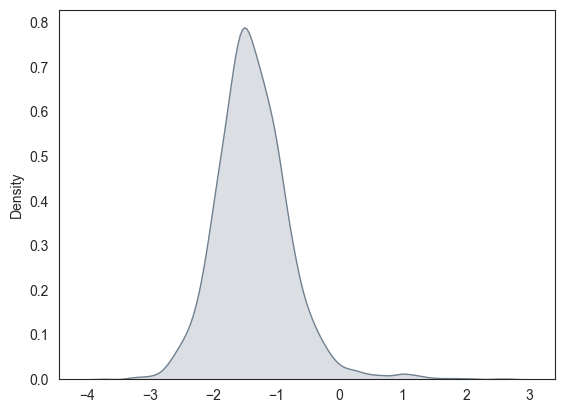

In [67]:
sns.kdeplot(votes['lm_resid'].values, shade=True, color='slategrey')


### TASK 11: Are our residuals normally distributed with a mean of zero? What does that mean?



No, the residuals seems to be skewed to the left. Residuals that are not normally distributed can indicate that the model does not capture all the patterns in the data. And since residuals are not centered at zero, it suggests a bias in the model predictions. This could be because of the multicollinearity found between predictor variables.

## Penalized regression: ridge penalty
In penalized regression, we intentionally bias the parameter estimates to stabilize them given collinearity in the dataset.

From https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

>As mentioned before, ridge regression performs ‘L2 regularization‘, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. Thus, ridge regression optimizes the following:

**Objective = RSS + α * (sum of square of coefficients)**

Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

* **α = 0:** The objective becomes same as simple linear regression. We’ll get the same coefficients as simple linear regression.

* **α = ∞:** The coefficients will approach zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.

* **0 < α < ∞:** The magnitude of α will decide the weightage given to different parts of objective. The coefficients will be somewhere between 0 and ones for simple linear regression."

In other words, the ridge penalty shrinks coefficients such that collinear coefficients will have more similar coefficient values. It has a "grouping" tendency.

In [68]:
# when L2=0, Ridge equals OLS
model = Ridge(alpha=1)

In [69]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.443 (0.023)


In [70]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)


[ 9.26657929e-02  4.05830016e-02 -1.65368938e-01  4.08087014e-01
  6.03983066e-01  1.43371906e-01  3.31368985e-01  5.89978152e-01
 -3.43227517e-01 -8.96919850e-05]


### Hyperparameter tuning
The L2 coefficient (called alpha above) is a free parameter (hyperparameter) in the model, meaning we can set it whatever value we feel is best.

In machine learning, we often try multiple options for these hyperparameters, and select the value with the highest model performance.

In [71]:
# Train on a range of alphas
alpha = np.arange(0,20,0.1)
ridge_tune=pd.DataFrame(alpha, columns=["alpha"])
ridge_tune['Score']=0
i=0
for a in alpha:
  model= Ridge(alpha=a)
  oos_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  #force scores to be positive
  oos_scores = absolute(oos_scores)
  ridge_tune.Score.loc[i]=mean(oos_scores)
  i=i+1


/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/3357503210.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  ridge_tune.Score.loc[i]=mean(oos_scores)
/var/folders/3h/x_sz2_zj2zx2vtvmg3jqk2y80000gn/T/ipykernel_7847/33575032

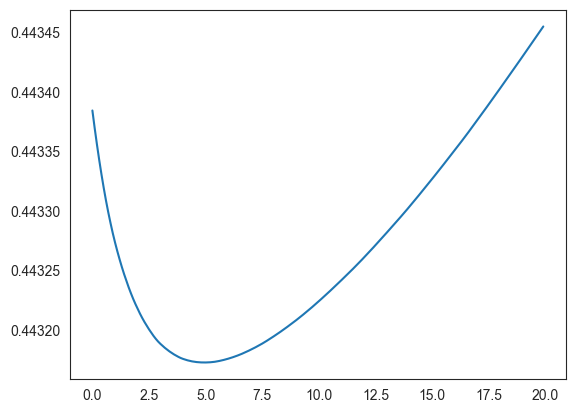

In [72]:
#  Plot model performance as a function of alpha
plt.plot(ridge_tune.alpha, ridge_tune.Score)
plt.show()
# What is the y-axis label? What is the x-axis label?

In [73]:
# Select the value of alpha which minimizes MAE
a2 = ridge_tune.alpha.iloc[ridge_tune['Score'].idxmin()]
a2

np.float64(4.9)

In [74]:
# Train model with optimized alpha
model = Ridge(alpha=a2)
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
vif['Ridge_coef']=model.coef_

[ 0.09327902  0.04123195 -0.16867684  0.40822624  0.59986229  0.14359781
  0.32914658  0.46875975 -0.33850578 -0.12138482]


## Penalized regression: lasso penalty

From https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/
> LASSO stands for Least Absolute Shrinkage and Selection Operator.

There are 2 key words here – **absolute** and **selection**.

Lets consider the former first and worry about the latter later.
.
Lasso regression performs L1 regularization, i.e. it adds a factor to the sum of absolute value of coefficients in the optimization objective. Thus, lasso regression optimizes the following:

**Objective = RSS + α * (sum of absolute value of coefficients)**

Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. Like that of ridge, α can take various values. Lets iterate it here briefly:

* **α = 0:** Same coefficients as simple linear regression
* **α = ∞:** All coefficients zero (same logic as before)
* **0 < α < ∞:** coefficients between 0 and that of simple linear regression

The lasso penalty shrinks unimportant coefficients down towards zero, automatically "selecting" important predictor variables. But what if that shrunken coefficient is induced by incidental collinearity (i.e. is a feature of how we sampled our data)?

In [75]:
# when L1=0, Lasso equals OLS
model = Lasso(alpha=0)

In [76]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.443 (0.023)


/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  m

In [77]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare to OLS coefficients?

[ 0.09240156  0.04025468 -0.16405097  0.40750435  0.60531978  0.14322466
  0.33221926  0.65300558 -0.34481735  0.06332694]


/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.565e+02, tolerance: 3.108e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in s

In [78]:
# when L1 approaches infinity, coefficients will become exactly zero, and MAE equals the variance of our response variable:
model = Lasso(alpha=10000000)

In [79]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.808 (0.038)


In [80]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?

[ 0.  0. -0.  0.  0.  0.  0.  0.  0. -0.]


### Hyperparameter tuning
Just like with the ridge penalty, we want to select the value of alpha that minimizes error in the lasso model.

We'll use hyperparameter tuning again to do this:

In [81]:
# Define range of alphas:
alpha = np.arange(0,.02,0.0001)
lasso_tune=pd.DataFrame(alpha, columns=["alpha"])
lasso_tune['Score']=0
i=0
for a in alpha:
  model= Lasso(alpha=a)
  oos_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
  #force scores to be positive
  oos_scores = absolute(oos_scores)
  lasso_tune.Score.loc[i]=mean(oos_scores)
  i=i+1


/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/liyangqin/ear609/EnvDatSci/.venv/lib/python3.9/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return

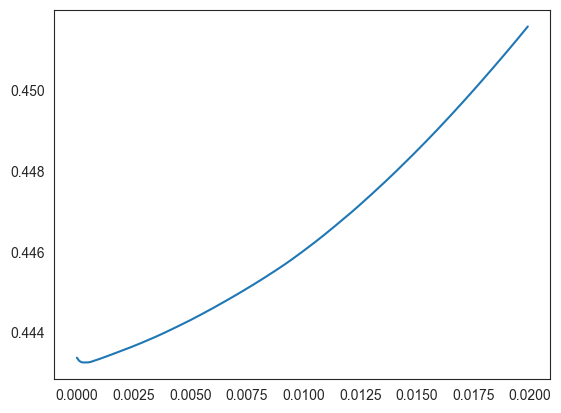

In [82]:
# Plot model performance as a function of alpha:
plt.plot(lasso_tune.alpha, lasso_tune.Score)
plt.show()
# What is the y-axis label? What is the x-axis label?

In [83]:
a1 = lasso_tune.alpha.iloc[lasso_tune['Score'].idxmin()]
a1

np.float64(0.0004)

In [84]:
# Train model with optimal alpha1
model= Lasso(alpha=a1)
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)

vif['LASSO_coef']= model.coef_

[ 0.09241895  0.04013387 -0.1650658   0.40806082  0.60322119  0.14308454
  0.33045773  0.5892348  -0.34161976 -0.        ]


### Penalized regression: elastic net penalty

In other words, the lasso penalty shrinks unimportant coefficients down towards zero, automatically "selecting" important predictor variables. The ridge penalty shrinks coefficients of collinear predictor variables nearer to each other, effectively partitioning the magnitude of response from the response variable between them, instead of "arbitrarily" partitioning it to one group.

We can also run a regression with a linear combination of ridge and lasso, called the elastic net, that has a cool property called "group selection."

The ridge penalty still works to distribute response variance equally between members of "groups" of collinear predictor variables. The lasso penalty still works to shrink certain coefficients to exactly zero so they can be ignored in model formulation. The elastic net produces models that are both sparse and stable under collinearity, by shrinking parameters of members of unimportant collinear predictor variables to exactly zero:

In [85]:
# Explore the parameters in the ElasticNet fuction.
# Which variable represents the ridge coefficient? Which parameter represents the lasso coefficient?
?ElasticNet

Init signature:
ElasticNet(
    alpha=1.0,
    *,
    l1_ratio=0.5,
    fit_intercept=True,
    precompute=False,
    max_iter=1000,
    copy_X=True,
    tol=0.0001,
    warm_start=False,
    positive=False,
    random_state=None,
    selection='cyclic',
)
Docstring:     
Linear regression with combined L1 and L2 priors as regularizer.

Minimizes the objective function::

        1 / (2 * n_samples) * ||y - Xw||^2_2
        + alpha * l1_ratio * ||w||_1
        + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

If you are interested in controlling the L1 and L2 penalty
separately, keep in mind that this is equivalent to::

        a * ||w||_1 + 0.5 * b * ||w||_2^2

where::

        alpha = a + b and l1_ratio = a / (a + b)

The parameter l1_ratio corresponds to alpha in the glmnet R package while
alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio
= 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable,
unless you supply your own sequence of alpha.

Read mo

In [86]:
# when L1 approaches infinity, certain coefficients will become exactly zero, and MAE equals the variance of our response variable:
model = ElasticNet(alpha=.1, l1_ratio=.1)

In [87]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.463 (0.018)


In [88]:
model.fit(X,Y)
#Print out the model coefficients
print(model.coef_)
#How do these compare with OLS coefficients above?
vif["ElNet_coef"]=model.coef_

[ 0.10111346  0.03223866 -0.21256541  0.32175318  0.42555362  0.12942274
  0.24424956  0.25221275 -0.14226098 -0.23277554]


### TASK 12: Match these elastic net coefficients up with your original data. Do you see a logical grouping(s) between variables that have non-zero coefficients?

I can group them by four categories in general: Demographic, education, political preferences and income. In demographic grouping, the two variables are RHI125214 and RHI225214, they can provide how race/ethnicity influence the final election results. In education, HSG495213 and INC910213 can be grouped with EDU685213, in which they describe Median value of owner-occupied housing units, 2009-2013, Per capita money income in past 12 months (2013 dollars), 2009-2013 and Bachelor’s degree or higher, percent of persons age 25+, 2009-2013, respectively. These variables logically group together, as both relate to education and may capture different but related aspects of education. Pct_gop_12 and pct_dem_12 can be grouped together as to show the political trend in voters. 

In [89]:
print(vif)

   VIF Factor    features  OLS_coef  Ridge_coef  LASSO_coef  ElNet_coef
0    1.362116   PST120214  0.092397    0.093279    0.092419    0.101113
1  474.911345   SEX255214  0.040248    0.041232    0.040134    0.032239
2  152.727545   RHI125214 -0.164033   -0.168677   -0.165066   -0.212565
3    6.706154   RHI225214  0.407481    0.408226    0.408061    0.321753
4   20.453035   EDU685213  0.605333    0.599862    0.603221    0.425554
5    1.476210   VET605213  0.143221    0.143598    0.143085    0.129423
6   10.424362   HSG495213  0.332232    0.329147    0.330458    0.244250
7  226.780100  pct_gop_12  0.654336    0.468760    0.589235    0.252213
8   65.034208   INC910213 -0.344835   -0.338506   -0.341620   -0.142261
9  103.301737  pct_dem_12  0.064669   -0.121385   -0.000000   -0.232776


## Extra Credit:
We saw how to tune individual parameters above. The elastic net regression here has two free parameters. How can you select the best values for these two free parameters?

Demonstrate in the cell below.

In [ ]:
# Extra credit scratch cell:
